In [1]:
import numpy as np
import pandas as pd

In [2]:
import plotly.graph_objects as go

labels = ['cancer','non cancer']
values = [89117,130908]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.06])])

fig.update_layout(autosize=False, width=600, height = 400,
                  
                  title ={'text':'lable distribution','y':0.9,'x':0.5},
                 
                  font = dict(size = 18))
                  
fig.show()

In [3]:
data = '/kaggle/input/histopathology-cancer-detection/train'

labels = pd.read_csv('/kaggle/input/histopathology-cancer-detection/train_labels.csv')

images_train = labels

images_train['label'] = images_train['label'].astype(str)

images_train['id'] = labels['id'] + '.tif'

In [4]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [5]:
labels.describe()

,id,label
count,220025,220025
unique,220025,2
top,f38a6374c348f90b587e046aac6079959adf3835.tif,0
freq,1,130908


In [6]:
import os

data_path = '/kaggle/input/histopathology-cancer-detection/train'

image_files = os.listdir(data_path)

# Remove the file extension from the image file names
image_ids = [os.path.splitext(file)[0] for file in image_files]

# Create a DataFrame with the image ids
image_ids_df = pd.DataFrame({'id': image_ids})

# Merge the image ids DataFrame with the labels DataFrame
labels_path = '/kaggle/input/histopathology-cancer-detection/train_labels.csv'
labels_df = pd.read_csv(labels_path)
merged_df = pd.merge(image_ids_df, labels_df, on='id')

In [7]:
print(len(merged_df))
print(len(labels_df))

220025
220025


In [8]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(merged_df, test_size=0.2, stratify=merged_df['label'], random_state=42)

In [10]:
print("Number of training samples: ", len(train_data))
print("Number of testing samples: ", len(test_data))

Number of training samples:  176020
Number of testing samples:  44005


In [9]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.optimizers import Adam

# **MODEL 1**

In [11]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))

batch_size = 256

model.build(input_shape=(batch_size, 64, 64, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (256, 62, 62, 16)         448       
_________________________________________________________________
conv2d_1 (Conv2D)            (256, 60, 60, 16)         2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (256, 30, 30, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (256, 28, 28, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (256, 26, 26, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (256, 13, 13, 32)         0         
_________________________________________________________________
flatten (Flatten)            (256, 5408)               0

In [12]:
RANDOM_STATE=1
BATCH_SIZE = 256

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale=1./255, validation_split=0.25)

data_train = generator.flow_from_dataframe(
    dataframe = images_train,
    x_col='id', # filenames
    y_col='label', # labels
    directory=data,
    subset='training',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    target_size=(64, 64))

data_validate=generator.flow_from_dataframe(
    dataframe=images_train,
    x_col='id', # filenames
    y_col='label', # labels
    directory=data,
    subset="validation",
    class_mode='binary',
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    target_size=(64, 64))

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


In [14]:
opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
hist = model.fit(data_train, validation_data=data_validate, epochs=10)

Epoch 1/10
645/645 [==============================] - 1061s 2s/step - loss: 0.5093 - accuracy: 0.7494 - val_loss: 0.4551 - val_accuracy: 0.7942
Epoch 2/10
645/645 [==============================] - 302s 469ms/step - loss: 0.4490 - accuracy: 0.7949 - val_loss: 0.4313 - val_accuracy: 0.8062
Epoch 3/10
645/645 [==============================] - 266s 413ms/step - loss: 0.4323 - accuracy: 0.8043 - val_loss: 0.4346 - val_accuracy: 0.7992
Epoch 4/10
645/645 [==============================] - 272s 422ms/step - loss: 0.4210 - accuracy: 0.8106 - val_loss: 0.4135 - val_accuracy: 0.8173
Epoch 5/10
645/645 [==============================] - 261s 404ms/step - loss: 0.4114 - accuracy: 0.8162 - val_loss: 0.4000 - val_accuracy: 0.8237
Epoch 6/10
645/645 [==============================] - 282s 437ms/step - loss: 0.4035 - accuracy: 0.8209 - val_loss: 0.4076 - val_accuracy: 0.8213
Epoch 7/10
645/645 [==============================] - 279s 433ms/step - loss: 0.3955 - accuracy: 0.8251 - val_loss: 0.3874 - v

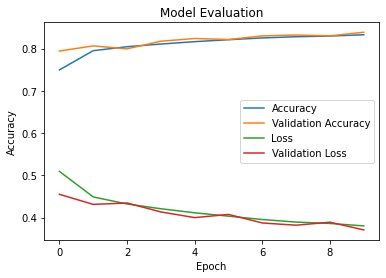

In [17]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

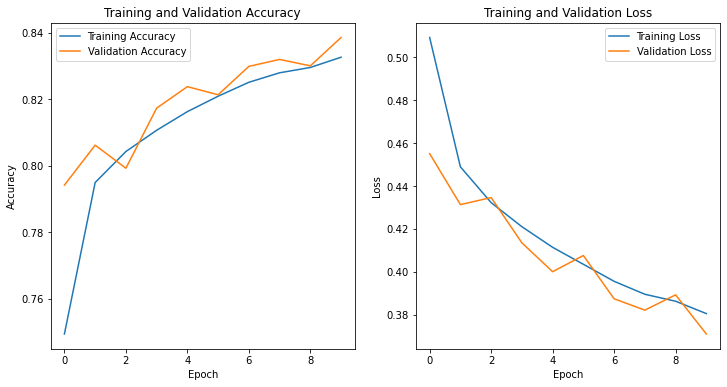

In [18]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# plot accuracy
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# plot loss
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()